<div>
    <h2><center>Thickness inversion for Valley glaciers</center></h2>
</div>

This notebook uses the ITS LIVE surface velocities and ice thickness geotiffs to propagate ice thickness in areas where the ice is in a valley configuration. We make several assumptions:

- Flux is mostly conserved along a flowline, with a change in mass balance removing material
- The bed has the shape of a parabolla, symetric or asymetric
- The highest surface velocity along a transect is always the thickest ice point
- The average velocity in the ice column is equal to the surface velocity multiplied by a slip-factor (between 0.8 and 1)



In [62]:
# Fetch the path for essential python scripts

import os
import sys
path =  os.getcwd()
# Avoid Windows users to have issues with how paths are written
path = path.replace('\\','/')

# Import python scripts from notebooks folder
sys.path.append(path + '/scripts')
%matplotlib widget

In [63]:
# Import all the necessary packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import markdown 

matplotlib.rcParams['figure.figsize'] = [9, 5]
matplotlib.rcParams["figure.autolayout"] = True

from velocity_widget import ITSLIVE
velocity_widget = ITSLIVE()
plt.close()
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles, ImageOverlay, WidgetControl
from ipywidgets import widgets, HTML, Output, Layout
from rasterio import Affine as A
from rasterio.warp import reproject, Resampling
import rasterio as rio
import rioxarray
import xarray as xr
import numpy as np
import time
from pyproj import Transformer
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import geopandas as gpd
import ipyleaflet as ipl
import math
import pandas as pd
import glob
import seaborn
import warnings
from skimage.draw import line
from scipy import interpolate
import PIL
import PIL.Image
from io import StringIO, BytesIO
from base64 import b64encode

**Instructions:**

You need an ice-thickness file, preferably geotiff or tif. Save it in the "Thickness" folder, and input the name in the cell below as well as the file format.
After that there are mainly 3 steps:
- AOI selection
- Fluxgate / Centerline seed selection
- Input selection


In [64]:
# Name of your thickness file in the Thickness folder
name_file = 'malaspina_Tober'

# Format of the file (without the ".", ex: "tif")
format = 'tif'

In [65]:
# Open thickness tif and reproject it to the right CRS
thickness =  xr.open_dataarray(f"{path}/Thickness/{name_file}.{format}").rio.reproject(f"EPSG:4326").sel(band=1)

In [66]:
# Code to display arrays on ipyleaflet maps, from https://github.com/jupyter-widgets/ipyleaflet/issues/705

def project_array(array, bounds, refinement=2):
    """
    Project a numpy array defined in WGS84 coordinates to Mercator Web coordinate system
    
    ipyleaflets use the Mercator Web coordinate system.
    :arg array: Data in 2D numpy array
    :arg bounds: Image latitude, longitude bounds, [(lat_min, lon_min), (lat_max, lon_max)]
    :kwarg int refinement: Scaling factor for output array resolution.
        refinement=1 implies that output array has the same size as the input.
    """
    with rio.Env():

        (lat_min, lon_min), (lat_max, lon_max) = bounds
        nlat, nlon = array.shape
        dlat = (lat_max - lat_min)/nlat
        dlon = (lon_max - lon_min)/nlon
        src_transform = A.translation(lon_min, lat_min) * A.scale(dlon, dlat)
        src_crs = {'init': 'EPSG:4326'}

        nlat2 = nlat*refinement
        nlon2 = nlon*refinement
        dst_shape = (nlat2, nlon2)
        dst_crs = {'init': 'EPSG:3857'}
        bbox = [lon_min, lat_min, lon_max, lat_max]
        dst_transform, width, height = rio.warp.calculate_default_transform(
            src_crs, dst_crs, nlon, nlat, *bbox, dst_width=nlon2, dst_height=nlat2)
        dst_shape = height, width
        destination = np.zeros(dst_shape)

        reproject(
            array,
            destination,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)
        return destination


def make_imageoverlay(array, bounds, mask=None, colormap='Blues', proj_refinement=4):
    """
    Make ImageOverlay from numpy array.
    
    
    :arg array: Data in 2D numpy array.
    :arg bounds: Image latitude, longitude bounds, [(lat_min, lon_min), (lat_max, lon_max)]
    :kwarg mask: Optional mask to mark missing data in the array. If mask=None and array is
        a masked array, its mask is used instead.
    :kwarg colormap: matplotlib colormap
    :kwarg int refinement: Scaling factor for output array resolution.
        refinement=1 implies that output array has the same size as the input.
    """
    if mask is None and hasattr(array, 'mask'):
        mask = array.mask
    # project to Mercator Web coordinates
    array_proj = project_array(array, bounds, refinement=proj_refinement)
    # map data to colors
    norm = plt.Normalize()
    cmap = plt.get_cmap(colormap)
    array_mapped = cmap(norm(array_proj))
    # convert to 8 bit int
    array_int = np.uint8(array_mapped*255)
    # make an image
    im = PIL.Image.new('RGBA', array_proj.shape[::-1], color=None)
    im_data = PIL.Image.fromarray(array_int)
    im_mask = None
    if mask is not None:
        assert mask.shape == array.shape, 'array and mask shapes must be identical'
        mask = project_array(mask.astype(float), bounds, refinement=proj_refinement)
        # NOTE image mask marks non-masked pixels
        mask_int = np.uint8(255*(1 - mask).astype(float))
        im_mask = PIL.Image.fromarray(mask_int, mode='L')
    im.paste(im_data, mask=im_mask)
    # store image in memory
    f = BytesIO()
    im.save(f, 'png')
    data = b64encode(f.getvalue())
    data = data.decode('ascii')
    imgurl = 'data:image/png;base64,' + data
    io = ImageOverlay(url=imgurl, bounds=bounds)
    return io

**Instructions:**

Zoom to your Area Of Interest (AOI). To draw the AOI, you need to drop two points: for the two opposite corners of the AOI.
Right-clicking once will drop one marker. Repeat a second time (at another location), it will drop a 2nd marker and draw the AOI as a blue rectangle.
If you made a mistake, just repeat the process. 

I could not figure out how to delete automatically the AOI and points if you make a mistake. 
Your thickness raster should be drawn on the map.

**DISCLAIMER**
Choose an AOI bigger than your thickness file. I had issues having the xarray slice extactly at the dimensions of the AOI, which introduces errors in the code.


In [67]:
dates_range = widgets.SelectionRangeSlider(
    options=[i for i in range(546)],
    index=(1, 120),
    continuous_update=False,
    description='Interval (days): ',
    orientation='horizontal',
    layout={'width': '90%',
            'display': 'flex'},
    style={'description_width': 'initial'})

variables =  widgets.Dropdown(
    options=['v', 'v_error', 'vx', 'vy'],
    description='Variable: ',
    disabled=False,
    value='v',
    layout={'width': '20%',
            'display': 'flex'},
    style={'description_width': 'initial'})

plot_type =  widgets.Dropdown(
    options=['location', 'satellite'],
    description='Plot By: ',
    disabled=False,
    value='location',
    layout={'width': '20%',
            'display': 'flex'},
    style={'description_width': 'initial'})

plot_button =  widgets.Button(
    description='Plot',
    button_style='primary',
    icon='line-chart',
    style={'description_width': 'initial'})

get_points =  widgets.Button(
    description='Get points',
    button_style='primary',
    icon='line-chart',
    style={'description_width': 'initial'})

clear_button =  widgets.Button(
    description='Clear Points',
    # button_style='warning',
    icon="trash",
    style={'description_width': 'initial'})

latitude = widgets.BoundedFloatText(
    value=0.0,
    min=-90.0,
    max=90.0,
    step=0.1,
    description='Lat: ',
    disabled=False,
    style={'description_width': 'initial'},
    layout={'width': '20%',
            'display': 'flex'},
)

longitude = widgets.BoundedFloatText(
    value=0.0,
    min=-180.0,
    max=180.0,
    step=0.1,
    description='Lon: ',
    disabled=False,
    style={'description_width': 'initial'},
    layout={'width': '20%',
            'display': 'flex'},
)

add_button =  widgets.Button(
    description='Add Point',
    # button_style='info',
    icon="map-marker",
    style={'description_width': 'initial'})

include_running_mean =  widgets.Checkbox(
            value=False,
            description="Include Running Mean",
            style={'description_width': 'initial'},
            disabled=False,
            indent=False,
            tooltip="Plot running mean through each time series",
            layout=widgets.Layout(width="25%"),
        )

export_button = widgets.Button(
    description='Export Data',
    # button_style='info',
    icon="file-export",
    style={'description_width': 'initial'})

data_link = widgets.HTML(
    value="<br>"
)

# If this congiguration changes we need to rerun the cell.
config = { 
    "plot": "v", # or other ITS_LIVE variables: vx, vy ...
    "min_separation_days": 1,
    "max_separation_days": 90,
    "color_by": "location", # valid values: satellite, points
    "verbose": True, # print operations
    "runnig_mean": True,
    "coords": {
        "latitude": latitude,
        "longitude": longitude
    },
    "data_link": data_link
}


def plotter(whatever):
    list_files = glob.glob(f'{pathsave}*.nc')

    fig, ax = plt.subplots(len(list_files), figsize=(10,10))

    if len(list_files) == 1:
        if type_dataset == "Yearly":
            ax.pcolormesh(xr.open_dataset(list_files[0]).x.values,xr.open_dataset(list_files[0]).y.values,xr.open_dataset(list_files[0]).v.values)
        else:
            ax.pcolormesh(xr.open_dataset(list_files[0]).x.values,xr.open_dataset(list_files[0]).y.values,np.nanmean(xr.open_dataset(list_files[0]).v.values,axis = 0))
    else:
        if type_dataset == "Yearly":
            for i in range(len(list_files)):
                ax[i].pcolormesh(xr.open_dataset(list_files[i]).x.values,xr.open_dataset(list_files[i]).y.values,xr.open_dataset(list_files[i]).v.values)
        else:
            for i in range(len(list_files)):
                ax[i].pcolormesh(xr.open_dataset(list_files[i]).x.values,xr.open_dataset(list_files[i]).y.values,np.nanmean(xr.open_dataset(list_files[i]).v.values,axis = 0))


def update_variable(change):
        if change['type'] == 'change' and change['name'] == 'value':
            config["plot"] = variables.value
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def update_range(change):
        if change['type'] == 'change' and change['name'] == 'value':
            start, end = change['new']
            config["min_separation_days"] = start
            config["max_separation_days"] = end
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def update_plottype(change):
        if change['type'] == 'change' and change['name'] == 'value':
            config["color_by"] = plot_type.value
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def update_mean(change):
        if change['type'] == 'change' and change['name'] == 'value':
            config["running_mean"] = include_running_mean.value
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def add_point(event):
    coords = (latitude.value, longitude.value)
    velocity_widget.add_point(coords)
    
def export_ts(event):
    velocity_widget.export_data()

get_points.on_click(velocity_widget.plot_time_series)
plot_button.on_click(plotter)
clear_button.on_click(velocity_widget.clear_points)


add_button.on_click(add_point)
dates_range.observe(update_range, 'value')
plot_type.observe(update_plottype, 'value')
variables.observe(update_variable, 'value')
include_running_mean.observe(update_mean, 'value')

layout = widgets.Layout(align_items='stretch',
                        display='flex',
                        flex_flow='row wrap',
                        border='none',
                        grid_template_columns="repeat(auto-fit, minmax(720px, 1fr))",
                        # grid_template_columns='48% 48%',
                        width='99%',
                        height='100%')

velocity_widget.set_config(config)

velocity_widget.fig.canvas.capture_scroll = True

#### Display thickness on map

# We have to flip the array in order to have it displayed correctly
array = np.flip(thickness.values, axis = 0)
# For a reason, if there are NaNs the array is not displayed on the map. We change NaNs to value and mask this value out
array[np.isnan(array)] = -9999
mask = array<=-9999
# Grab the extent of the array
bounds = [(thickness.y.values.min(), thickness.x.values.min()), (thickness.y.values.max(), thickness.x.values.max())]
# Create the layer containing the array
io = make_imageoverlay(array, bounds, mask=mask, colormap='viridis')
# Add layer to map
velocity_widget.map.add_layer(io)
####

# We render the widget
widgets.GridBox([
                widgets.VBox([velocity_widget.map,
                            widgets.HBox([latitude, longitude, add_button, clear_button], layout=widgets.Layout(align_items="flex-start",
                                                                                                                flex_flow='row wrap'))],
                            layout=widgets.Layout(min_width="100%",
                                                    display="flex",
                                                    # height="100%",
                                                    # max_height="100%",
                                                    max_width="100%"))],

                layout=layout)

GridBox(children=(VBox(children=(Map(center=[57.2, -49.43], controls=(ZoomControl(options=['position', 'zoom_i…

In [68]:
# Gather filenames in the corresponding regional composite images
list_files = glob.glob(f'{path}/Datacubes/Composite/{velocity_widget.name_region[0]}/*')
# Make sure that Windows users won't encounter troubles with the '\\' character in the path
list_files = [(list_files[i].replace('\\','/')) for i in range(len(list_files))]
# Create path to save figures and files generated in this notebook
pathsave = velocity_widget.path_composite_datacubes.replace(velocity_widget.path_composite_datacubes.split('/')[-2], list_files[0].split('/')[-2] ).replace('Datacubes','Output').replace('\\','/')
# Create output folder
os.makedirs(pathsave, exist_ok = True)
# Open dataset and crop to blue AOI (defined in the map above)
ds = xr.open_dataset(list_files[0]).sel(x=slice(velocity_widget.xmin_proj,velocity_widget.xmax_proj), y=slice(velocity_widget.ymax_proj,velocity_widget.ymin_proj))
# Gather the coordinates of the blue AOI
coords = [(velocity_widget.ymin, velocity_widget.xmin), (velocity_widget.ymax, velocity_widget.xmax)]

**Instructions:**
- Zoom to the AOI
- Select points inside the blue rectangle with left-clicks, overlapping with your ice thickness. The points should be red.
- Right-click once, choose a location for seeding your streamline.
- Left-click to place one seed point, it should be green.

The fluxgate's shape does not matter as we use the velocity components to calculate fluxes.

In [31]:
def handle_click(**kwargs):
    global i
    global n
    global c
    # If left click, add marker, grab coordinates and store in the coordinates array
    # Ideally, I would like 'click' to be 'leftclick' if that exists
    if kwargs.get('type') == 'click':
        
        icon = ipl.AwesomeIcon(name='fa-cog', marker_color = colors[c])
        m.add_layer(ipl.Marker(location=kwargs.get('coordinates'), icon=icon,  draggable=True))
        coordinates[n,i,:] = (kwargs['coordinates'])
        i += 1

    
    # If right click, change color of marker, change column in coordinates, reinitialize the row counter
    elif kwargs.get('type') == 'contextmenu':
        i = 0
        n += 1
        c += 1
        if c > len(colors)-1:
            c = 0




# Initialize coordinates array
coordinates=np.full((1000,1000,2), np.nan)

# Initialize indices
i = 0
n = 0
c = 0
# Create a rotating array of colors to differenciate the markers
colors = ['red', 'green', 'blue', 'purple', 'gray', 'orange', 'beige']

# plot the map
m = ipl.Map(
    basemap=ipl.basemap_to_tiles(ipl.basemaps.Esri.WorldImagery),
    zoom=3,
    scroll_wheel_zoom=True
    ) 


# plot the AOI
rectangle = ipl.Rectangle(bounds=((coords[1][0], coords[1][1]), (coords[0][0], coords[0][1])))
m.add_layer(rectangle)
m.add_layer(io)

m.on_interaction(handle_click)
m

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

**Instructions:**
- slip_coefficient should be between 1 and 0.8. It represents the ratio between surface velocities and average velocities through the ice column. 0.95 means the average velocity is 95% of the surface velocity. If there are perfect slip conditions, the coefficient should be 1. If the bed is entirely frozen, the coefficient should be 0.8.
- timestep represents the amount of steps taken to calculate your centerline from the seedpoint. The smaller it is, the finer the centerline will be but the longer the code will take to run.
- threshold represents the minimum velocity considered for the glacier's edges. It is in m/yr, modify it accordingly to your liking. There is a figure showing where the edges are selected.


**Algorithm description:**
We use the composite velocities to create a centerline. At each point along this centerline, from the velocity components, we gather all the points perpendicular to the flowline. We start a pixel-by-pixel search along that linem frome the centerline, which will stop whenever a pixel's velocity is below the threshold. Once we have the edges of the glacier, we gather the indices of the maximum surface velocities. We use those to fit two parabolas, that we then merge to create an asymetric bed. 

In [41]:
# Slip coefficient
slip_coefficient = 0.95

# Velocity threshold for automatic glacier edges
threshold = 200

# Timestep for ODE solving (resolution of thickness inversion)
timestep = 0.005

# Maximum of the eval range (years)
tevalmax = 20

# streamline direction
sd = -1


In [56]:


# Create a function to match the resolution of the velocity field
def interpolator(ds_in, ds_match):
    return ds_in.interp(x = np.linspace(ds_in.x[0], ds_in.x[-1], ds_match.sizes['x']), y = np.linspace(ds_in.y[0], ds_in.y[-1], ds_match.sizes['y']))

# Convert the coordinates to the dataset's projection
transformer = Transformer.from_crs(4326, int(velocity_widget.proj_region[0]))
coords_proj = np.array([[pt for pt in transformer.itransform(coordinates[i])] for i in range(coordinates.shape[0])])

# Determine how many points there are per transect
inds_nan = [np.where(np.isnan(coords_proj[i,:,0]))[0][0] for i in range(0,n+1)]

# Open thickness tif and reproject it to the right CRS
thickness =  xr.open_dataarray(f"{path}/Thickness/{name_file}.{format}").rio.reproject(f"EPSG:{velocity_widget.proj_region[0]}").sel(band=1,x=slice(velocity_widget.xmin_proj,velocity_widget.xmax_proj), y=slice(velocity_widget.ymax_proj,velocity_widget.ymin_proj))

# Determine the variation of y and x along the [i,j] axis of the velocity datacube
yvar = ds.y.values[0] - ds.y.values[-1]
xvar = ds.x.values[0] - ds.x.values[-1]

# Compare the extents of each dataset, and grab those of the smallest one
if ds.x.values.max() > thickness.x.values.max():
    x_max_small = thickness.x.values.max()
    x_max_big = ds.x.values.max()
else: 
    x_max_small = ds.x.values.max()
    x_max_big = thickness.x.values.max()
if ds.y.values.max() > thickness.y.values.max():
    y_max_small = thickness.y.values.max()
    y_max_big = ds.y.values.max()
else: 
    y_max_small = ds.y.values.max()
    y_max_big = thickness.y.values.max()
    
if ds.x.values.min() < thickness.x.values.min():
    x_min_small = thickness.x.values.min()
    x_min_big = ds.x.values.min()
else: 
    x_min_small = ds.x.values.min()
    x_min_big = thickness.x.values.min()
if ds.y.values.min() < thickness.y.values.min():
    y_min_small = thickness.y.values.min()
    y_min_big = ds.y.values.min()
else: 
    y_min_small = ds.y.values.min()
    y_min_big = thickness.y.values.min()

# Match the thickness dataset to what overlaps from the velocity dataset. It sets the same resolution and extent for both dataset
thickness = interpolator(thickness, ds.vx.sel(x=slice(x_min_small, x_max_small), y=slice(y_max_small, y_min_small)))



topb = np.abs(ds.y.values - y_min_big).argmin() - np.abs(ds.y.values - y_min_small).argmin()
bottomb = np.abs(ds.y.values - y_max_small).argmin() - np.abs(ds.y.values - y_max_big).argmin()


leftb = np.abs(ds.x.values - x_min_small).argmin() - np.abs(ds.x.values - x_min_big).argmin()
rightb = np.abs(ds.x.values - x_max_big).argmin() - np.abs(ds.x.values - x_max_small).argmin()

# Extend the smallest dataset to match the big one
thickness = np.pad(thickness.values, ((topb, bottomb), (leftb, rightb)), mode='constant', constant_values=np.nan)

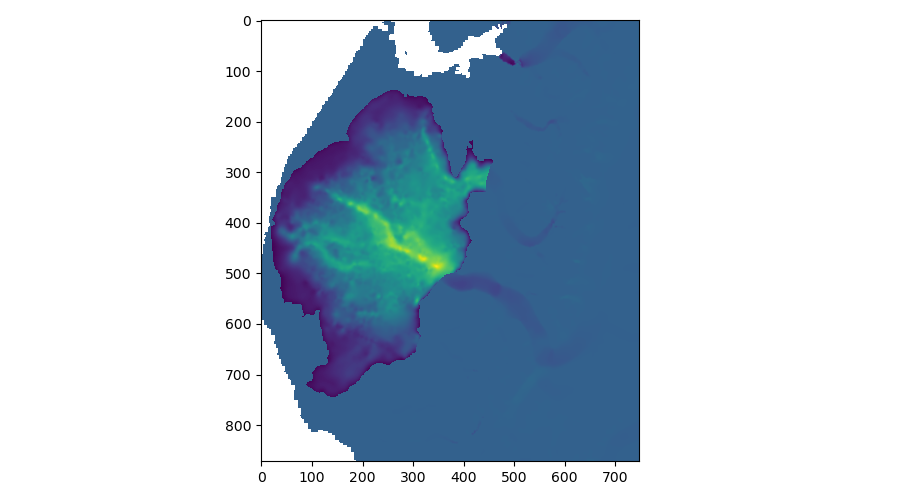

In [35]:
# Verify that both dataset overlap nicely. If the thickness is bigger than the velocity dataset, plot the thickness first
plt.figure()
plt.imshow(ds.vx.values)
plt.imshow(thickness)

In [42]:
# Retrieve the average velocity between each points
inds_midpoints = [line(np.abs(ds.y.values - coords_proj[0,i,1]).argmin(),
 np.abs(ds.x.values - coords_proj[0,i,0]).argmin(),
 np.abs(ds.y.values - coords_proj[0,i+1,1]).argmin(),
 np.abs(ds.x.values - coords_proj[0,i+1,0]).argmin()
 ) for i in range(inds_nan[0]-1)]

avx = [np.nanmean(ds.vx.values[
    inds_midpoints[i][0],
    inds_midpoints[i][1]
]
) for i in range(len(inds_midpoints))] # We have as many transects as sublists in inds_midpoints

avy = [np.nanmean(ds.vy.values[
    inds_midpoints[i][0],
    inds_midpoints[i][1]
]
) for i in range(len(inds_midpoints))] # We have as many transects as sublists in inds_midpoints

# Retrieve the average thickness between each points
inds_midpoints = [line(np.abs(ds.y.values - coords_proj[0,i,1]).argmin(),
 np.abs(ds.x.values - coords_proj[0,i,0]).argmin(),
 np.abs(ds.y.values - coords_proj[0,i+1,1]).argmin(),
 np.abs(ds.x.values - coords_proj[0,i+1,0]).argmin()
 ) for i in range(inds_nan[0]-1)]

ath = [np.nanmean(
    thickness[
        inds_midpoints[i][0],
         inds_midpoints[i][1]
    ]
) for i in range(len(inds_midpoints))] # We have as many transects as sublists in inds_midpoints

# Calculate spatial steps between each point
dy = coords_proj[0,1:inds_nan[0],1]-coords_proj[0,0:inds_nan[0]-1,1]
dx = coords_proj[0,1:inds_nan[0],0]-coords_proj[0,0:inds_nan[0]-1,0]

# Calculate total flux
Q = np.sum(np.array(ath) * (np.array(avx) * dy - np.array(avy) * dx))


# Grab the velocity arrays
vx = ds.vx.values
vy = ds.vy.values
x = ds.x.values
y = ds.y.values

# Create an empty array of bed values the size of the velocity array
thickness_propagated = np.full([vx.shape[0], vx.shape[1]], np.nan)

from scipy.interpolate import RegularGridInterpolator
X, Y = np.meshgrid(ds.x.values,ds.y.values)
fx = RegularGridInterpolator((y, x), vx, bounds_error=False, fill_value=None)
fy = RegularGridInterpolator((y, x), vy, bounds_error=False, fill_value=None)

# define the velocity function to be integrated, according to the streamline direction
def f(t, y):
    return np.squeeze([fy(y), fx(y)]) * sd

# Convert the coordinates to the dataset's projection
transformer = Transformer.from_crs(4326, 3413)
coords_proj = np.array([[pt for pt in transformer.itransform(coordinates[i])] for i in range(coordinates.shape[0])])

from scipy.integrate import solve_ivp
sol = solve_ivp(f, [0, tevalmax], [coords_proj[n,i-1,1],coords_proj[n,i-1,0]], t_eval=np.arange(0,tevalmax,timestep))

# Get inds of streamline
inds = np.array([(np.abs(y - sol.y[0,i]).argmin(), np.abs(x - sol.y[1,i]).argmin()) for i in range(len(sol.y[0]))])


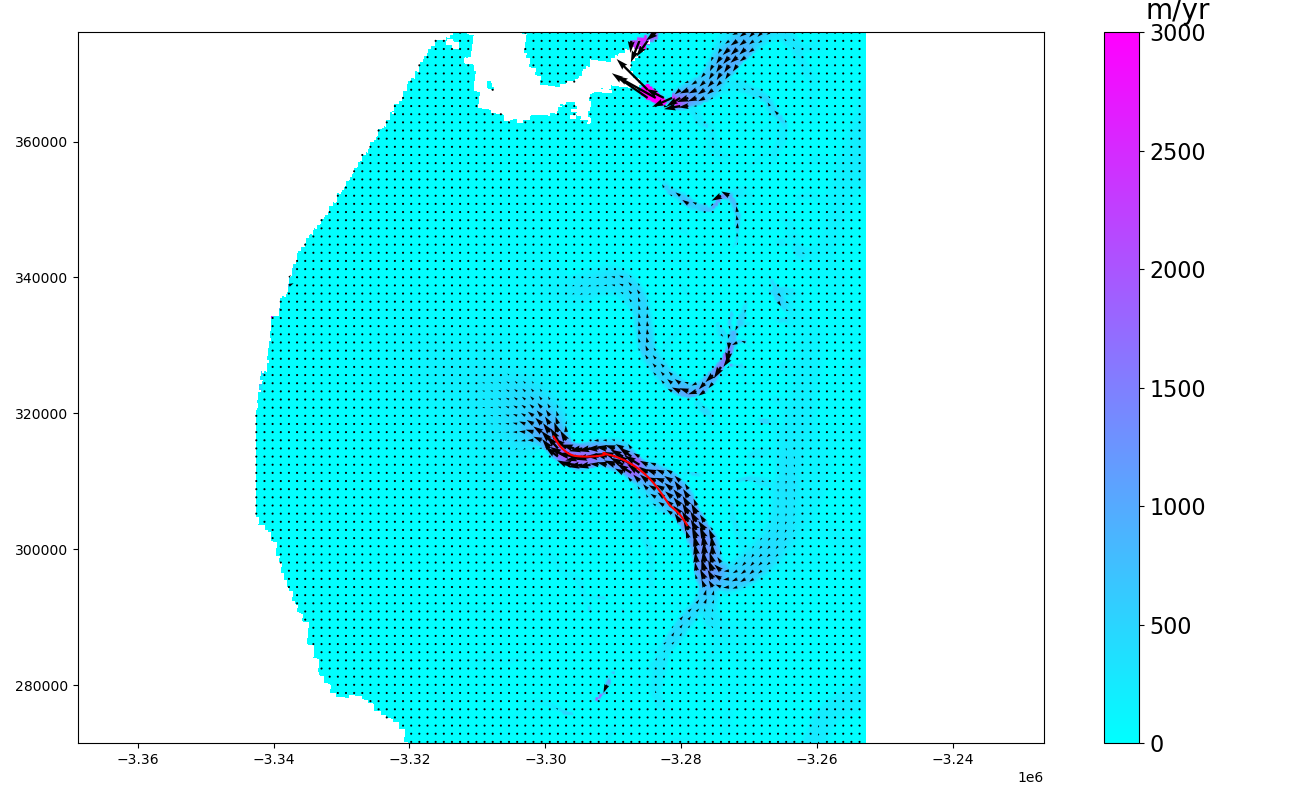

In [43]:
plt.figure(figsize=(13,8))

plt.pcolormesh(ds.x.values,ds.y.values,ds.v.values, shading='nearest', vmax=3000, alpha=1, cmap='cool')
clb=plt.colorbar()
clb.set_label('m/yr', labelpad=-20, y=1.05, rotation=0, fontsize=20)
clb.ax.tick_params(labelsize=16)
plt.quiver(ds.x.values[::10],ds.y.values[::10],ds.vx.values[::10,::10],ds.vy.values[::10,::10],scale=100000)
plt.axis('equal')
plt.plot(sol.y[1,:],sol.y[0,:],'r')



In [44]:
def streamliner(c, threshold):

    # Gather coordinates of streamline point 
    I= inds[c,0]
    J = inds[c,1]

    # Grab the velocity arrays
    vx = ds.vx.values
    vy = ds.vy.values

    # Calculate the coefficients of the line equation from the point's coordinates and its velocity vector
    a = vx[I,J]/vy[I,J]
    b = I - a * J

    # Find the intersection of the line with the edges of the matrix
    y1 = 0
    y2 = vx.shape[0]
    x1 = int(-b/a)
    x2 = int((y2-b)/a)

    # Collect all points between the two points at which the line intersects the velocity's edges
    inds_line = np.array(line(y1, x1, y2, x2))

    # Remove all points outside of the velocity's edges
    inds_line = np.array([inds_line[i,np.where(np.logical_and(inds_line[1]>=0, inds_line[1]<=vx.shape[1]-1))[0][:].astype('int')] for i in range(2)]).astype('int')

    # Grab the index of the streamline point in inds_line
    ind_stream = np.abs(inds_line[0,:] - I).argmin()

    # Find the first edge of the glacier
    for e1 in range(ind_stream+1, len(inds_line[0])):
        if np.sqrt(vx[inds_line[:,e1][0], inds_line[:,e1][1]]**2 + vy[inds_line[:,e1][0], inds_line[:,e1][1]]**2) < threshold:
            break

    # Find the second edge of the glacier
    for e2 in range(ind_stream-1, 0,-1):
            if np.sqrt(vx[inds_line[:,e2][0], inds_line[:,e2][1]]**2 + vy[inds_line[:,e2][0], inds_line[:,e2][1]]**2) < threshold:
                break

                
    return e1, e2, inds_line, c

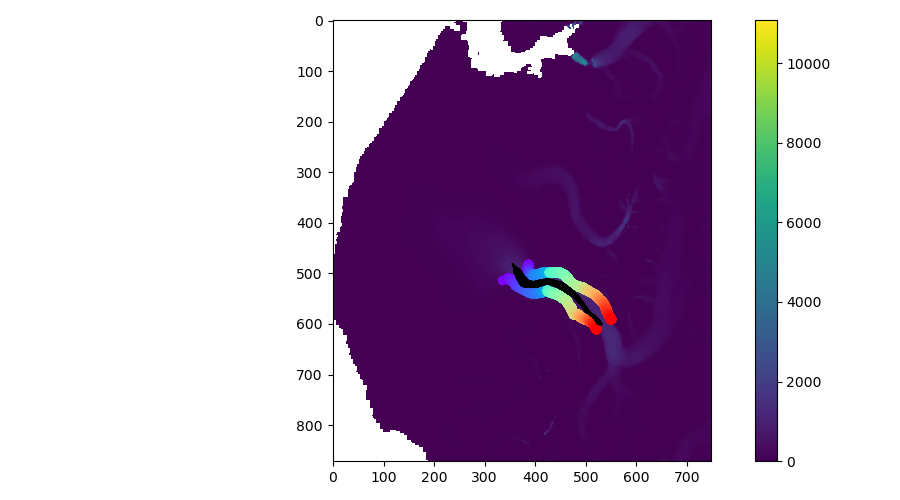

In [45]:
# Start figure
plt.figure()

# plot background velocities
plt.imshow(np.sqrt(vx**2 + vy**2))
plt.colorbar()

# Loop through X points along the streamline
X = len(sol.y[0])

# Create a custom colormap
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, X))

# Choose a threshold of minimum velocities to be considered as the edges of the glacier
threshold = 200 #[m/yr]

E1 = []
E2 = []

# Loop
for c, col in zip(range(0,X), colors):

    # Call the streamliner function
    e1, e2, inds_line, C = streamliner(c,threshold)
    
    # plot all lines computed that are perpendicular to the main flow
    #plt.plot(inds_line[1,:], inds_line[0,:])

    # plot velocity arrows of centerline points computed
    plt.quiver(inds[c,1],inds[c,0],vx[inds[c,0],inds[c,1]],vy[inds[c,0],inds[c,1]],scale=50000)

    # plot the edges of the glacier
    plt.scatter(inds_line[1,e1],inds_line[0,e1], color=col)
    plt.scatter(inds_line[1,e2],inds_line[0,e2], color=col)

    E1.append((inds_line[0,e1], inds_line[1,e1]))
    E2.append((inds_line[0,e2], inds_line[1,e2]))

In [46]:
def bed_propagation(c):
    # Gather coordinates of streamline point 
    I= inds[c,0]
    J = inds[c,1]

    # Grab the velocity arrays
    vx = ds.vx.values
    vy = ds.vy.values

    # Calculate the coefficients of the line equation from the point's coordinates and its velocity vector
    a = vx[I,J]/vy[I,J]
    b = I - a * J

    # Find the intersection of the line with the edges of the matrix
    y1 = 0
    y2 = vx.shape[0]
    x1 = int(-b/a)
    x2 = int((y2-b)/a)

    # Collect all points between the two points at which the line intersects the velocity's edges
    inds_line = np.array(line(y1, x1, y2, x2))

    # Remove all points outside of the velocity's edges
    inds_line = np.array([inds_line[i,np.where(np.logical_and(inds_line[1]>=0, inds_line[1]<=vx.shape[1]-1))[0][:].astype('int')] for i in range(2)]).astype('int')

    # Grab the index of the streamline point in inds_line
    ind_stream = np.abs(inds_line[0,:] - I).argmin()

    # Find the first edge of the glacier
    for e1 in range(ind_stream+1, len(inds_line[0])):
        if np.sqrt(vx[inds_line[:,e1][0], inds_line[:,e1][1]]**2 + vy[inds_line[:,e1][0], inds_line[:,e1][1]]**2) < threshold:
            break

    # Find the second edge of the glacier
    for e2 in range(ind_stream-1, 0,-1):
            if np.sqrt(vx[inds_line[:,e2][0], inds_line[:,e2][1]]**2 + vy[inds_line[:,e2][0], inds_line[:,e2][1]]**2) < threshold:
                break

    # Grab all velocities between the two points
    if e1 < e2:
        inds_line = inds_line[:,e1:e2]
    else:
        inds_line = inds_line[:,e2:e1]

    vxline = vx[inds_line[0], inds_line[1]]
    vyline = vy[inds_line[0], inds_line[1]]
    vline = np.sqrt(vxline**2 + vyline**2)

    # Grab the index of the fastest velocity
    ind_max_vel_line = np.where(vline == np.nanmax(vline))[0][0]

    # Interpolate the velocities along one line
    x = np.arange(-ind_max_vel_line, len(vline)-ind_max_vel_line)
    fvx = interpolate.interp1d(x, vxline, 'quadratic') # Interpolate vx
    fvy = interpolate.interp1d(x, vyline, 'quadratic') # Interpolate vy
    xnew = np.arange(-ind_max_vel_line, len(vline)-ind_max_vel_line-1, 0.01) # Create new interpolation domain
    vxnew= fvx(xnew) # Interpolate vx
    vynew= fvy(xnew) # Interpolate vy
    vnew= np.sqrt(vxnew**2 + vynew**2) # Calculate the velocity

    # Update the index of fastest velocity according to xnew
    ind_max_vel = np.where(vnew == np.nanmax(vnew))[0][0]
    xmin = xnew[0]
    xmax = xnew[-1]

    # Calculate the spatial step of xnew in the dataset's projection
    dxnew = (np.sqrt((ds.x.values[inds_line[0,0]]-ds.x.values[inds_line[0,-1]])**2 + (ds.y.values[inds_line[1,0]]-ds.y.values[inds_line[1,-1]])**2))/len(xnew)

    # Angle between first and last value of xnew, compared to the array's X axis (sanity check: if the flow is East-West in epsg:3413, vy is perpendicular to the fluxgate and sin(alpha) = 0, therfore vx doesn't participate)
    alpha = np.arctan((ds.y.values[inds_line[0,-1]]-ds.y.values[inds_line[0,0]])/(ds.x.values[inds_line[1,-1]]-ds.x.values[inds_line[1,0]]))

    # Calculate the maximum depth along the transect
    d = Q / (slip_coefficient *  
        np.sum(
            (1 - (xnew[0:ind_max_vel]**2/(xmin**2)))  * np.abs((vxnew[0:ind_max_vel] * (dxnew*np.sin(alpha)) - vynew[0:ind_max_vel] * (dxnew*np.cos(alpha))))) + 
            np.sum(
                (1 - (xnew[ind_max_vel:]**2/(xmax**2)))  * np.abs((vxnew[ind_max_vel:] * (dxnew*np.sin(alpha)) - vynew[ind_max_vel:] * (dxnew*np.cos(alpha))))))

    # plug-in equations for 2 parabolas that we joint in their middle
    thickness = np.append((-d*x[0:ind_max_vel_line]**2)/xmin**2 + d, (-d*x[ind_max_vel_line:]**2)/((xmax)**2) + d)

    return thickness, inds_line, vline

C:\Users\whisk\AppData\Local\Temp\ipykernel_18664\2546332836.py:70: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = np.arctan((ds.y.values[inds_line[0,-1]]-ds.y.values[inds_line[0,0]])/(ds.x.values[inds_line[1,-1]]-ds.x.values[inds_line[1,0]]))


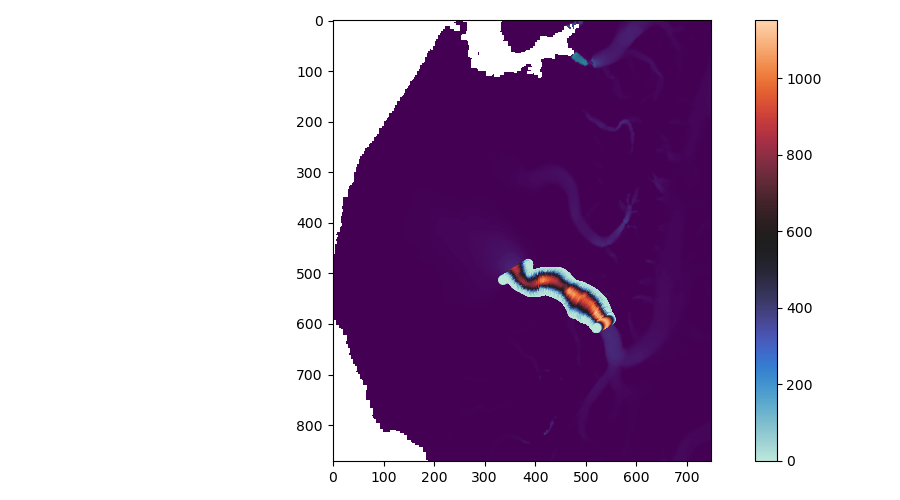

In [47]:
thickness_transects = []
v_transects = []
inds_pts_transects = []

for i in range(len(sol.y[0])):
    a,b,c = bed_propagation(i)
    thickness_transects.append(a)
    inds_pts_transects.append(b)
    v_transects.append(c)
    
vm  = int(np.nanmax(np.array([np.nanmax(thickness_transects[i]) for i in range(len(thickness_transects))])))

plt.figure()
plt.imshow(np.sqrt(vx**2+vy**2))

for i in range(len(thickness_transects)):
    plt.scatter(inds_pts_transects[i][1],inds_pts_transects[i][0], c=thickness_transects[i], cmap='icefire', vmax = vm)

plt.colorbar()

In [58]:
# Fill-in the new values in the thickness array but do not overwrite the cells where values already exist
for i in range(len(inds_pts_transects)):
    for j in range(len(inds_pts_transects[i][0])):
        if np.isnan(thickness[inds_pts_transects[i][0][j], inds_pts_transects[i][1][j]]):
            thickness[inds_pts_transects[i][0], inds_pts_transects[i][1]] = thickness_transects[i]

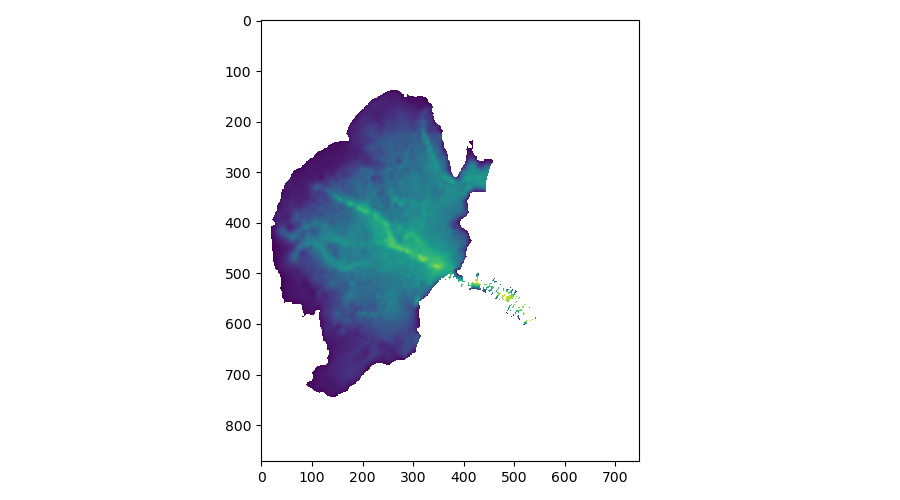

In [59]:
plt.figure()
plt.imshow(thickness)